<a href="https://colab.research.google.com/github/bathaee/QGAN-EQ-GAN/blob/main/Change_SamplerQNN_Forward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit --upgrade
!pip install qiskit-machine-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 22.4 MB/s eta 0:00:00


In [2]:
import torch
from qiskit import QuantumCircuit, execute, Aer,transpile
from qiskit.circuit.library import EfficientSU2,TwoLocal
from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.visualization import plot_histogram
from qiskit import Aer
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise
from qiskit.utils import algorithm_globals
from qiskit.providers import Options
from qiskit.utils import QuantumInstance
import qiskit.quantum_info as qi
from qiskit_aer.noise import NoiseModel, amplitude_damping_error,pauli_error, depolarizing_error

In [5]:
shots = 100000
sampler = Sampler()


sampler_n = Sampler(options={ "shots": shots, "seed": algorithm_globals.random_seed})

In [6]:
num_qubits = 2
qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)
qc_zofal = QuantumCircuit(num_qubits)
qc_zofal.h(qc.qubits)
qc_zofal_ = TwoLocal(num_qubits,
                     # Parameterized single qubit rotations
                     ['ry'],
                     'cz',  # Entangling gate
                     'full', # Entanglement structure: all to all
                     reps=1, # Number of layers
                     parameter_prefix='θ_g',
                     name='Generator',
                    insert_barriers=True)
qc_zofal.compose(qc_zofal_, inplace=True)
qc_zofal.decompose().draw()

┌─────────┐┌────────────┐ ░     ░ ┌────────────┐
q_0: ┤ U2(0,π) ├┤ Ry(θ_g[0]) ├─░──■──░─┤ Ry(θ_g[2]) ├
     ├─────────┤├────────────┤ ░  │  ░ ├────────────┤
q_1: ┤ U2(0,π) ├┤ Ry(θ_g[1]) ├─░──■──░─┤ Ry(θ_g[3]) ├
     └─────────┘└────────────┘ ░     ░ └────────────┘

In [7]:
p = qc_zofal.assign_parameters(algorithm_globals.random.random(qc_zofal.num_parameters))
p.measure_all()
print(p.decompose())

        ┌─────────┐┌───────────────────────┐ ░     ░ ┌───────────────────────┐»
   q_0: ┤ U2(0,π) ├┤ Ry(0.516044030495997) ├─░──■──░─┤ Ry(0.627538822303176) ├»
        ├─────────┤├───────────────────────┤ ░  │  ░ ├───────────────────────┤»
   q_1: ┤ U2(0,π) ├┤ Ry(0.976220350547896) ├─░──■──░─┤ Ry(0.236204281589399) ├»
        └─────────┘└───────────────────────┘ ░     ░ └───────────────────────┘»
meas: 2/══════════════════════════════════════════════════════════════════════»
                                                                              »
«         ░ ┌─┐   
«   q_0: ─░─┤M├───
«         ░ └╥┘┌─┐
«   q_1: ─░──╫─┤M├
«         ░  ║ └╥┘
«meas: 2/════╩══╩═
«            0  1 


In [8]:
#Custom Noise model for measurment, x and cx gates

# Error probabilities
prob_1 = 0.0  # 1-qubit gate
prob_2 = 0.0  # 2-qubit gate
prob_m = 0.1  # Measurment error

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)
error_meas = noise.pauli_error([('X',prob_m), ('I', 1 - prob_m)])

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['y'])
noise_model.add_all_qubit_quantum_error(error_2, ['cz'])
noise_model.add_all_qubit_quantum_error(error_meas, "measure")

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

#print(basis_gates)

In [9]:
backend = AerSimulator(noise_model=noise_model)
backend.set_options(noise_model=noise_model)
job = execute(p, backend)
result = job.result()
# Get the counts from the simulation result
counts = result.get_counts()
print(counts)

{'01': 146, '11': 368, '00': 69, '10': 441}


In [10]:
def create_generator() -> TorchConnector:
    #sim_noise = AerSimulator(noise_model=noise_model)
    #qcn = transpile(qc, sim_noise)
    qnn = SamplerQNN(
        sampler = sampler,
        circuit= qc_zofal,
        input_params=[],
        weight_params=qc_zofal.parameters,
        sparse=False,
    )    
    initial_weights = algorithm_globals.random.random(qc_zofal.num_parameters)

    return TorchConnector(qnn, initial_weights)

generator = create_generator()
print(generator(torch.tensor([])).reshape(-1,1))
print()
print(generator.parameters())

tensor([[0.0029],
        [0.4103],
        [0.1495],
        [0.4374]], grad_fn=<ReshapeAliasBackward0>)

<generator object Module.parameters at 0x7f57df732960>


In [11]:
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

In [12]:
num_dim =1
discriminator = Discriminator(num_dim)
print(discriminator)

Discriminator(
  (linear_input): Linear(in_features=1, out_features=20, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (linear20): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [13]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

In [14]:
from torch.optim import Adam

lr = 0.01  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)

In [15]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

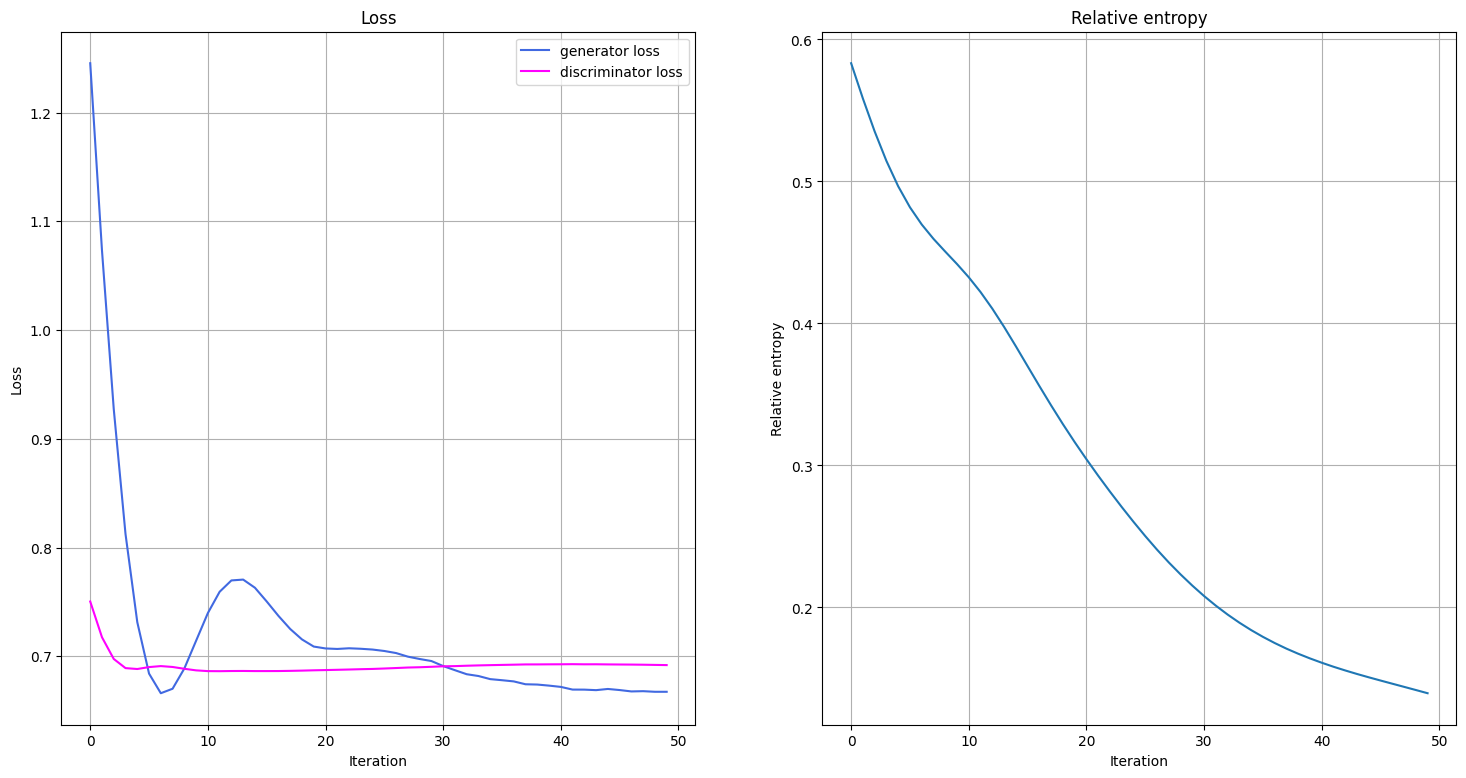

Fit in 29.22 sec


In [16]:
import time
from scipy.stats import multivariate_normal, entropy

grid_elements = [[1],[2],[3],[4]]
prob_data = [0.1, 0.3, 0.5, 0.1]
n_epochs = 50

num_qnn_outputs = 4

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # Configure input
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # Configure samples
    samples = torch.tensor(grid_elements, dtype=torch.float)
    disc_value = discriminator(samples)

    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # Train generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)

    # store for plotting
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train Discriminator
    discriminator_optimizer.zero_grad()

    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
    entropy_values.append(entropy_value)

    plot_training_progress()

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

In [17]:
with torch.no_grad():
    generated_probabilities = generator().numpy()

with torch.no_grad():
    generated_probabilities = generator().numpy()

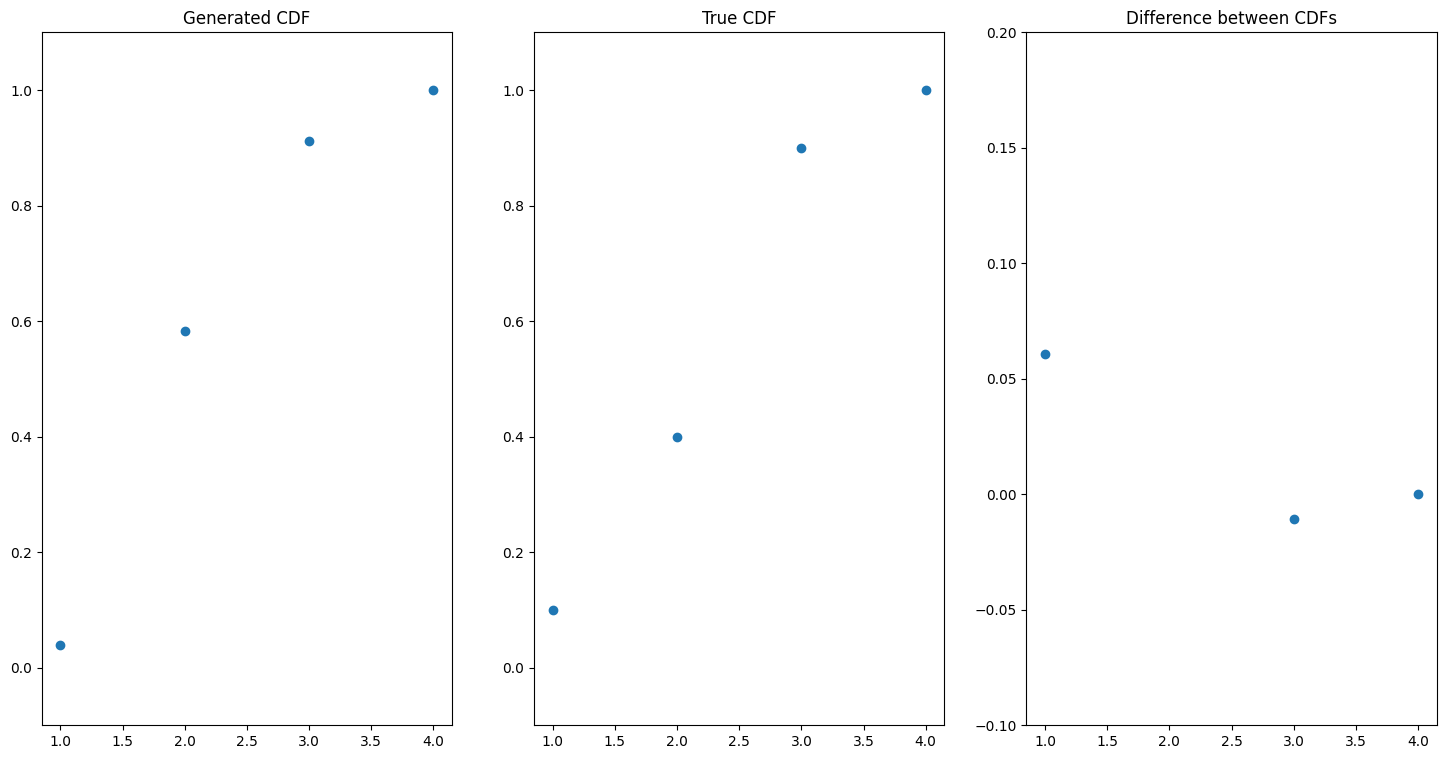

In [18]:
fig = plt.figure(figsize=(18, 9))
import numpy as np

# Generated CDF
gen_prob_grid = np.cumsum(generated_probabilities)

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("Generated CDF")
ax1.set_ylim(-0.1, 1.1)
ax1.scatter(grid_elements,gen_prob_grid)

# Real CDF
real_prob_grid = np.cumsum(prob_data)

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("True CDF")
ax2.set_ylim(-0.1, 1.1)
ax2.scatter(grid_elements,real_prob_grid)

# Difference
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("Difference between CDFs")
ax3.set_ylim(-0.1, 0.2)
ax3.scatter(grid_elements,real_prob_grid-gen_prob_grid)
plt.show()

In [ ]:
grid_elements = [[1],[2],[3],[4]]
samples = torch.tensor(grid_elements, dtype=torch.float)
disc_value = discriminator(samples)
print(grid_elements)
print(samples)
print(disc_value)

[[1], [2], [3], [4]]
tensor([[1.],
        [2.],
        [3.],
        [4.]])
tensor([[0.5327],
        [0.5131],
        [0.5037],
        [0.4943]], grad_fn=<SigmoidBackward0>)


In [ ]:
gen_dist = generator(torch.tensor([])).reshape(-1, 1)
print(torch.tensor([]))
print(gen_dist.detach())

tensor([])
tensor([[0.1057],
        [0.4431],
        [0.2776],
        [0.1737]])


In [ ]:
prob_data = [0.1, 0.3, 0.5, 0.1]
real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)
valid = torch.ones(4, 1, dtype=torch.float)
fake = torch.ones(4, 1, dtype=torch.float)
print(real_dist)
print(valid)

tensor([[0.1000],
        [0.3000],
        [0.5000],
        [0.1000]])
tensor([[1.],
        [1.],
        [1.],
        [1.]])


In [ ]:
generator_optimizer.zero_grad()


In [ ]:
generator_loss = adversarial_loss(disc_value, valid, gen_dist.detach())
print(generator_loss)

tensor(0.6749, grad_fn=<NegBackward0>)


In [ ]:
generator_loss.backward(retain_graph=True)
generator_optimizer.step()

In [ ]:
discriminator_optimizer.zero_grad()

real_loss = adversarial_loss(disc_value, valid, real_dist)
fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
discriminator_loss = (real_loss + fake_loss) / 2
print(discriminator_loss)

tensor(0.6757, grad_fn=<DivBackward0>)


In [ ]:
discriminator_loss.backward()
discriminator_optimizer.step()

In [ ]:
from scipy.stats import multivariate_normal, entropy
entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
print(entropy_value)
print(gen_dist.detach().squeeze().numpy())
print(prob_data)

0.11109840318877957
[0.10568087 0.44305262 0.27760056 0.17366599]
[0.1, 0.3, 0.5, 0.1]


In [ ]:
disc_value = discriminator(samples)
print(disc_value)

tensor([[0.5602],
        [0.5575],
        [0.5638],
        [0.5707]], grad_fn=<SigmoidBackward0>)


In [ ]:
print(generator(torch.tensor([])).reshape(-1,1))

tensor([[0.1057],
        [0.4431],
        [0.2776],
        [0.1737]], grad_fn=<ReshapeAliasBackward0>)
